In [ ]:
import tensorflow as tf

import pathlib
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

np.set_printoptions(precision=4)

#### tf.data

The tf.data API enables you to build complex input pipelines from simple, reusable pieces. The tf.data API makes it possible to handle large amounts of data, read from different data formats, and perform complex transformations.

The tf.data API introduces a tf.data.Dataset abstraction that represents a sequence of elements, in which each element consists of one or more components. For example, in an image pipeline, an element might be a single training example, with a pair of tensor components representing the image and its label.

There are two distinct ways to create a dataset:

A data source constructs a Dataset from data stored in memory or in one or more files.

A data transformation constructs a dataset from one or more tf.data.Dataset objects.

##### Dataset Structure

A dataset contains elements that each have the same (nested) structure and the individual components of the structure can be of any type representable by tf.TypeSpec, including tf.Tensor, tf.sparse.SparseTensor, tf.RaggedTensor, tf.TensorArray, or tf.data.Dataset.

The Dataset.element_spec property allows you to inspect the type of each element component. The property returns a nested structure of tf.TypeSpec objects, matching the structure of the element, which may be a single component, a tuple of components, or a nested tuple of components. For example:


In [ ]:
dataset1 = tf.data.Dataset.from_tensor_slices(tf.random.uniform([4, 10]))

dataset1.element_spec

##### Reading input data

**Numpy Arrays**

In [ ]:
numpy_array = np.array([1, 2, 3])
dataset = tf.data.Dataset.from_tensor_slices(numpy_array)
print(numpy_array.shape)
print(dataset.element_spec)

for elem in dataset:
    print(elem)

##### Consuming TFRecord data

The TFRecord file format is a simple record-oriented binary format that many TensorFlow applications use for training data. The tf.data.TFRecordDataset class enables you to stream over the contents of one or more TFRecord files as part of an input pipeline.

In [ ]:
# Creates a dataset that reads all of the examples from two files.
fsns_test_file = tf.keras.utils.get_file("fsns.tfrec", "https://storage.googleapis.com/download.tensorflow.org/data/fsns-20160927/testdata/fsns-00000-of-00001")
dataset = tf.data.TFRecordDataset(filenames = [fsns_test_file])
dataset

In [ ]:
raw_example = next(iter(dataset))
parsed = tf.train.Example.FromString(raw_example.numpy())

parsed.features.feature['image/text']

##### Consuming text data

The tf.data.TextLineDataset provides an easy way to extract lines from one or more text files. Given one or more filenames, a TextLineDataset will produce one string-valued element per line of those files.

In [ ]:
directory_url = 'http://storage.googleapis.com/download.tensorflow.org/data/illiad/'
file_names = ['cowper.txt', 'derby.txt', 'butler.txt']

file_paths = [
    tf.keras.utils.get_file(file_name, directory_url + file_name)
    for file_name in file_names
]

In [ ]:
dataset = tf.data.TextLineDataset(file_paths)

# Here are the first few lines of the first file:
for line in dataset.take(5):
    print(line.numpy())

##### Consuming CSV data

The CSV file format is a popular format for storing tabular data in plain text.

In [ ]:
titanic_file = tf.keras.utils.get_file("train.csv", "http://storage.googleapis.com/tf-datasets/titanic/train.csv")
df = pd.read_csv(titanic_file)
df.head()

In [ ]:
titanic_slices = tf.data.Dataset.from_tensor_slices(dict(df))

for feature_batch in titanic_slices.take(1):
    for key, value in feature_batch.items():
        print("  {!r:20s}: {}".format(key, value))


In [ ]:
titanic_batches = tf.data.experimental.make_csv_dataset(
    titanic_file, batch_size=4,
    label_name="survived")

In [ ]:
for feature_batch, label_batch in titanic_batches.take(1):
    print("'survived': {}".format(label_batch))
    print("features:")
    for key, value in feature_batch.items():
        print("  {!r:20s}: {}".format(key, value))

##### Training workflows

The tf.data API offers two main ways to process multiple epochs of the same data.

The simplest way to iterate over a dataset in multiple epochs is to use the Dataset.repeat() transformation.

Another way is to use the Dataset.shuffle() transformation maintains a fixed-size buffer and chooses the next element uniformly at random from that buffer.

##### Optimize performance by creating a pipelining

    1. Prefetch
    2. Interleave
    3. Map func
    4. Cache

In [ ]:
data_dir = tf.keras.utils.get_file(origin='https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
                                         fname='flower_photos', untar=True)
data_dir = pathlib.Path(data_dir)

image_count = len(list(data_dir.glob('*/*.jpg')))

CLASS_NAMES = np.array([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"])

print("Images Count: ", image_count)
IMG_HEIGHT = 224
IMG_WIDTH = 224

In [ ]:
# Define Preprocess functions. 
def get_label(file_path):
    # convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
    # The second to last is the class-directory
    label =  parts[-2] == CLASS_NAMES
    return label

def decode_img(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_jpeg(img, channels=3)
    # Use `convert_image_dtype` to convert to floats in the [0,1] range.
    img = tf.image.convert_image_dtype(img, tf.float32)
    # resize the image to the desired size.
    return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])

def process_path(file_path):
    label = get_label(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

**Naive Approach**

Under the hood, this is how your execution time was spent:

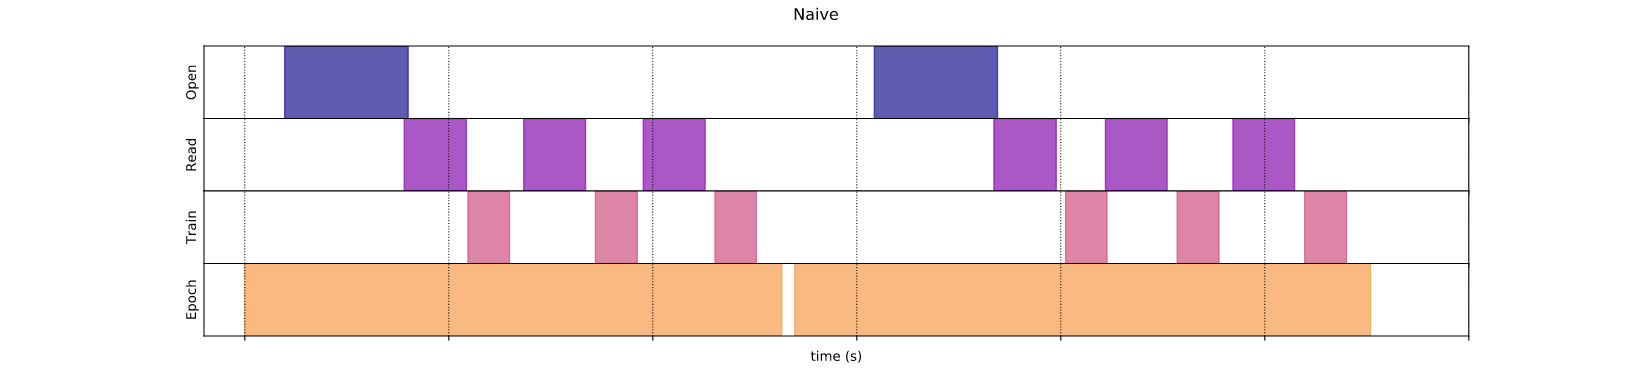

However, in a naive synchronous implementation like here, while your pipeline is fetching the data, your model is sitting idle. Conversely, while your model is training, the input pipeline is sitting idle. The training step time is thus the sum of all, opening, reading and training time.

Workflow for every batch:

    opening a file if it hasn't been opened yet,
    fetching a data entry from the file,
    using the data for training.

In [ ]:
# List files
dataset = tf.data.Dataset.list_files(str(data_dir/'*/*'))

# Shuffle data
dataset = dataset.shuffle(image_count)

# Apply map function to convert the image to (feature, label)
dataset = dataset.map(process_path)

# Batch the input data
dataset = dataset.batch(batch_size=32)

Build pipeline for better performance

In [ ]:
# List files
dataset = tf.data.Dataset.list_files(str(data_dir/'*/*'))

# Shuffle data
dataset = dataset.shuffle(image_count)

# Apply map function to convert the image to (feature, label)
# num_parallel_calls => the implementation creates a threadpool, which is used to fetch inputs from cycle elements asynchronously and in parallel.
dataset = dataset.map(process_path, num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Batch the input data
dataset = dataset.batch(batch_size=32)

# Prefetch next batch of data for training
# buffer_size => representing the maximum number of elements that will be buffered when prefetching.
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

### Distributed training with TensorFlow


tf.distribute.Strategy is a TensorFlow API to distribute training across multiple GPUs, multiple machines or TPUs. Using this API, you can distribute your existing models and training code with minimal code changes.

##### Using tf.distribute.Strategy with tf.keras.Model.fit


In [ ]:
# create the strategy
mirrored_strategy = tf.distribute.MirroredStrategy()

# Open the scope and define the model
with mirrored_strategy.scope():
    model = tf.keras.Sequential([tf.keras.layers.Dense(1, input_shape=(1,))])

model.compile(loss='mse', optimizer='sgd')

In [ ]:
dataset = tf.data.Dataset.from_tensors(([1.], [1.])).repeat(100).batch(10)
model.fit(dataset, epochs=2)
model.evaluate(dataset)

**Image Classification End to End example with tf.Distribute Strategy**

In [ ]:
# Data Load & Preprocess.
data_dir = tf.keras.utils.get_file(origin='https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
                                         fname='flower_photos', untar=True)
data_dir = pathlib.Path(data_dir)

image_count = len(list(data_dir.glob('*/*.jpg')))

CLASS_NAMES = np.array([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"])

print("Images Count: ", image_count)

# Define Preprocess functions. 
@tf.function
def get_label(file_path):
    # convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
    # The second to last is the class-directory
    label =  parts[-2] == CLASS_NAMES
    return label

@tf.function
def decode_img(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_jpeg(img, channels=3)
    # Use `convert_image_dtype` to convert to floats in the [0,1] range.
    img = tf.image.convert_image_dtype(img, tf.float32)
    # resize the image to the desired size.
    return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])

@tf.function
def process_path(file_path):
    label = get_label(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label


**Setup input pipeline**

When training a model with multiple GPUs, you can use the extra computing power effectively by increasing the batch size. In general, use the largest batch size that fits the GPU memory, and tune the learning rate accordingly.

In [ ]:
strategy = tf.distribute.MirroredStrategy()
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

In [ ]:
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE_PER_REPLICA = 32
BATCH_SIZE = BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync

dataset = tf.data.Dataset.list_files(str(data_dir/'*/*'))
dataset = dataset.shuffle(image_count)
dataset = dataset.map(process_path, num_parallel_calls=tf.data.experimental.AUTOTUNE).cache()
dataset = dataset.batch(batch_size=BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [ ]:
for element, label in dataset.take(1):
    print(label)

**Create the model**

In [ ]:
with strategy.scope():
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
    model.add(tf.keras.layers.MaxPooling2D((2, 2)))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(64, activation='relu'))
    model.add(tf.keras.layers.Dense(5, activation='softmax'))
    
    model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

In [ ]:
model.summary()

In [ ]:
model.fit(dataset, epochs=3)

##### Using tf.distribute.Strategy with Estimator
